# 1. VGG
### Finetuning VGG on Fruit dataset
<img src="images/VGG16.png" style="width:750px;height:350px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **VGG16 Model** </center></caption>

In [1]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

# https://www.kaggle.com/paultimothymooney/blood-cells
# train_path = '../large_files/blood_cell_images/TRAIN'
# valid_path = '../large_files/blood_cell_images/TEST'

# https://www.kaggle.com/moltean/fruits
# train_path = '../large_files/fruits-360/Training'
# valid_path = '../large_files/fruits-360/Validation'
train_path = '../large_files/fruits-360/Training'
valid_path = '../large_files/fruits-360/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')


# look at an image for fun
# plt.imshow(image.load_img(np.random.choice(image_files)))
# plt.show()




# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)





# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
# for x, y in test_gen:
#   print("min:", x[0].min(), "max:", x[0].max())
#   plt.title(labels[np.argmax(y[0])])
#   plt.imshow(x[0])
#   plt.show()
#   break




# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

print(len(image_files), len(valid_image_files) , len(valid_image_files) // batch_size, len(image_files) // batch_size)
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)





def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

/home/thunguyen/miniconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Confusion matrix, without normalization
[[486   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 489   0]
 [ 38   0   0 ...   0   0   0]]


<Figure size 640x480 with 2 Axes>

Confusion matrix, without normalization
[[163   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [ 14   0   0 ...   0   0   0]]


<Figure size 640x480 with 2 Axes>

# 2. Resnet 

### 2.1- The identity block


The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

Here're the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1).   Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the channels axis.  
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the channels axis.   
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the channels axis. Note that there is no ReLU activation function in this component. 

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Exercise**: Implement the ResNet identity block. We have implemented the first component of the main path. Please read over this carefully to make sure you understand what it is doing. You should implement the rest. 
- To implement the Conv2D step: [See reference](https://keras.io/layers/convolutional/#conv2d)
- To implement BatchNorm: [See reference](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the channels axis))
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [See reference](https://keras.io/layers/merge/#add)

In [4]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
#     from __future__ import print_function, division
#     from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tf_resnet_convblock import ConvLayer, BatchNormLayer

def conv2d(inputs, filters,kernel_size=[1,1], padding = 'valid', kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 0)):
  return tf.layers.conv2d(inputs = inputs, filters = filters, kernel_size = kernel_size, padding = padding, activation = None, kernel_initializer = kernel_initializer)


class IdentityBlock:
  def __init__(self, mi, feature_sizes):
    self.sess = None 
    self.input = tf.placeholder(tf.float32, shape=(1, 224, 224, mi))

    self.conv1 = conv2d(inputs = self.input, filters = feature_sizes[0])
    self.bn1 = tf.contrib.layers.batch_norm(inputs = self.conv1)
    self.relu1 = tf.nn.relu(self.bn1)

    self.conv2 = conv2d(inputs = self.relu1, filters = feature_sizes[1], kernel_size= [3,3], padding = 'same')
    self.bn2 = tf.contrib.layers.batch_norm(inputs = self.conv2)
    self.relu2 = tf.nn.relu(self.bn2)

    self.conv3 = conv2d(inputs = self.relu2, filters = feature_sizes[2])
    self.bn3 = tf.contrib.layers.batch_norm(inputs = self.conv3)

    self.output = tf.nn.relu(self.bn3 + self.input)



  def predict(self, X):
    assert (self.sess is not None)
    return self.sess.run(self.output, feed_dict ={self.input: X})



if __name__ == '__main__':
  identity_block = IdentityBlock(256,[64, 64, 256])

  # make a fake image
  X = np.random.random((1, 224, 224, 256))

  init = tf.global_variables_initializer()
  with tf.Session() as session:
    identity_block.sess = session
    session.run(init)

    output = identity_block.predict(X)
    print("output.shape:", output.shape)
    print("input.shape: ", X.shape)


output.shape: (1, 224, 224, 256)
input.shape:  (1, 224, 224, 256)


### 2.2 - The convolutional block

You've implemented the ResNet identity block. Next, the ResNet "convolutional block" is the other type of block. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Convolutional block** </center></caption>

The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s).  
- The first BatchNorm is normalizing the channels axis.  
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1).  
- The second BatchNorm is normalizing the channels axis.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1).  
- The third BatchNorm is normalizing the channels axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s)
- The BatchNorm is normalizing the channels axis.

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    
**Exercise**: Implement the convolutional block. We have implemented the first component of the main path; you should implement the rest. As before, always use 0 as the seed for the random initialization, to ensure consistency with our grader.
- [Conv Hint](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm Hint](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- For the activation, use:  `Activation('relu')(X)`
- [Addition Hint](https://keras.io/layers/merge/#add)

In [1]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#d: feature length, mi: num input feature map, mo: ...

class ConvBlock:
  def __init__(self, mi, fm_sizes, f):
    self.session = None

    #Weights
    self.W1 = tf.get_variable('W1',[1, 1, mi, fm_sizes[0]],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    self.W2 = tf.get_variable('W2',[f, f, fm_sizes[0], fm_sizes[1]],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    self.W3 = tf.get_variable('W3',[1, 1, fm_sizes[1], fm_sizes[2]],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    self.Wf = tf.get_variable('Wf',[1, 1, mi, fm_sizes[2]],initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    #batch norm:
    self.mean1 = tf.Variable(np.zeros(fm_sizes[0], dtype=np.float32), trainable=False)
    self.mean2 = tf.Variable(np.zeros(fm_sizes[1], dtype=np.float32), trainable=False)
    self.mean3 = tf.Variable(np.zeros(fm_sizes[2], dtype=np.float32), trainable=False)
    self.meanf = tf.Variable(np.zeros(fm_sizes[2], dtype=np.float32), trainable=False)
    self.var1 = tf.Variable(np.ones(fm_sizes[0], dtype=np.float32), trainable=False)
    self.var2 = tf.Variable(np.ones(fm_sizes[1], dtype=np.float32), trainable=False)
    self.var3 = tf.Variable(np.ones(fm_sizes[2], dtype=np.float32), trainable=False)
    self.varf = tf.Variable(np.ones(fm_sizes[2], dtype=np.float32), trainable=False)
    self.gamma1        = tf.Variable(np.ones(fm_sizes[0], dtype=np.float32))
    self.gamma2        = tf.Variable(np.ones(fm_sizes[1], dtype=np.float32))
    self.gamma3        = tf.Variable(np.ones(fm_sizes[2], dtype=np.float32))
    self.gammaf        = tf.Variable(np.ones(fm_sizes[2], dtype=np.float32))
    self.beta1         = tf.Variable(np.zeros(fm_sizes[0], dtype=np.float32))
    self.beta2         = tf.Variable(np.zeros(fm_sizes[1], dtype=np.float32))
    self.beta3         = tf.Variable(np.zeros(fm_sizes[2], dtype=np.float32))
    self.betaf         = tf.Variable(np.zeros(fm_sizes[2], dtype=np.float32))

    self.input = tf.placeholder(tf.float32, shape=(1, 224, 224, mi))
    self.output = self.forward(self.input)


  def forward(self,X):
    FX = tf.nn.conv2d(X, self.W1, strides=[1,1,1,1],padding = 'VALID')
    FX = tf.nn.batch_normalization(FX,self.mean1,self.var1,self.gamma1,self.beta1,1e-3)
    FX = tf.nn.relu(FX)

    FX = tf.nn.conv2d(FX, self.W2, strides=[1,1,1,1],padding = 'SAME')
    FX = tf.nn.batch_normalization(FX,self.mean2,self.var2,self.gamma2,self.beta2,1e-3)
    FX = tf.nn.relu(FX)

    FX = tf.nn.conv2d(FX, self.W3, strides=[1,1,1,1],padding = 'VALID')
    FX = tf.nn.batch_normalization(FX,self.mean3,self.var3,self.gamma3,self.beta3,1e-3)

    ##shortcut
    GX = tf.nn.conv2d(X, self.Wf, strides=[1,1,1,1],padding = 'VALID')
    GX = tf.nn.batch_normalization(GX,self.meanf,self.varf,self.gammaf,self.betaf,1e-3)
    return tf.nn.relu(FX+GX)

  def predict(self, X):
    assert(self.session is not None)
    return self.session.run(self.output, feed_dict={self.input: X})


if __name__ == '__main__':
  conv_block = ConvBlock(mi=3, fm_sizes=[64, 64, 256], f=3)


  # make a fake image
  X = np.random.random((1, 224, 224, 3))

  init = tf.global_variables_initializer()
  with tf.Session() as session:
    conv_block.session = session
    session.run(init)

    output = conv_block.predict(X)
    print("input.shape:", X.shape)
    print("output.shape:", output.shape)

/home/thunguyen/miniconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


input.shape: (1, 224, 224, 3)
output.shape: (1, 224, 224, 256)


### 2.3 - Resnet full block

<img src="images/Resnet.png" style="width:350px;height:900px;transform:rotate(-90deg);" class="rotate90" >
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Resnet Model** </center></caption>

In [5]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


# Let's go up to the end of the first conv block
# to make sure everything has been loaded correctly
# compared to keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense
from keras.applications.resnet50 import preprocess_input, decode_predictions

from tf_resnet_convblock import ConvLayer, BatchNormLayer, ConvBlock
from tf_resnet_identity_block import IdentityBlock
from tf_resnet_first_layers import ReLULayer, MaxPoolLayer


# NOTE: dependent on your Keras version
#       this script used 2.1.1
# [<keras.engine.topology.InputLayer at 0x112fe4358>,
#  <keras.layers.convolutional.Conv2D at 0x112fe46a0>,
#  <keras.layers.normalization.BatchNormalization at 0x112fe4630>,
#  <keras.layers.core.Activation at 0x112fe4eb8>,
#  <keras.layers.pooling.MaxPooling2D at 0x10ed4be48>,
#
#  ConvBlock
#  IdentityBlock x 2
#
#  ConvBlock
#  IdentityBlock x 3
#
#  ConvBlock
#  IdentityBlock x 5
#
#  ConvBlock
#  IdentityBlock x 2
#
#  AveragePooling2D
#  Flatten
#  Dense (Softmax)
# ]


# define some additional layers so they have a forward function
class AvgPool:
  def __init__(self, ksize):
    self.ksize = ksize

  def forward(self, X):
    return tf.nn.avg_pool(
      X,
      ksize=[1, self.ksize, self.ksize, 1],
      strides=[1, 1, 1, 1],
      padding='VALID'
    )

  def get_params(self):
    return []

class Flatten:
  def forward(self, X):
    return tf.contrib.layers.flatten(X)

  def get_params(self):
    return []


def custom_softmax(x):
  m = tf.reduce_max(x, 1)
  x = x - m
  e = tf.exp(x)
  return e / tf.reduce_sum(e, -1)


class DenseLayer:
  def __init__(self, mi, mo):
    self.W = tf.Variable((np.random.randn(mi, mo) * np.sqrt(2.0 / mi)).astype(np.float32))
    self.b = tf.Variable(np.zeros(mo, dtype=np.float32))

  def forward(self, X):
    # unfortunately these all yield slightly different answers
    # return tf.nn.softmax(tf.matmul(X, self.W) + self.b)
    # return custom_softmax(tf.matmul(X, self.W) + self.b)
    # return keras.activations.softmax(tf.matmul(X, self.W) + self.b)
    return tf.matmul(X, self.W) + self.b

  def copyFromKerasLayers(self, layer):
    W, b = layer.get_weights()
    op1 = self.W.assign(W)
    op2 = self.b.assign(b)
    self.session.run((op1, op2))

  def get_params(self):
    return [self.W, self.b]


class TFResNet:
  def __init__(self):
    self.layers = [
      # before conv block
      ConvLayer(d=7, mi=3, mo=64, stride=2, padding='SAME'),
      BatchNormLayer(64),
      ReLULayer(),
      MaxPoolLayer(dim=3),
      # conv block
      ConvBlock(mi=64, fm_sizes=[64, 64, 256], stride=1),
      # identity block x 2
      IdentityBlock(mi=256, fm_sizes=[64, 64, 256]),
      IdentityBlock(mi=256, fm_sizes=[64, 64, 256]),
      # conv block
      ConvBlock(mi=256, fm_sizes=[128, 128, 512], stride=2),
      # identity block x 3
      IdentityBlock(mi=512, fm_sizes=[128, 128, 512]),
      IdentityBlock(mi=512, fm_sizes=[128, 128, 512]),
      IdentityBlock(mi=512, fm_sizes=[128, 128, 512]),
      # conv block
      ConvBlock(mi=512, fm_sizes=[256, 256, 1024], stride=2),
      # identity block x 5
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      # conv block
      ConvBlock(mi=1024, fm_sizes=[512, 512, 2048], stride=2),
      # identity block x 2
      IdentityBlock(mi=2048, fm_sizes=[512, 512, 2048]),
      IdentityBlock(mi=2048, fm_sizes=[512, 512, 2048]),
      # pool / flatten / dense
      AvgPool(ksize=7),
      Flatten(),
      DenseLayer(mi=2048, mo=1000)
    ]
    self.input_ = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))
    self.output = self.forward(self.input_)

  def copyFromKerasLayers(self, layers):
    # conv
    self.layers[0].copyFromKerasLayers(layers[1])
    # bn
    self.layers[1].copyFromKerasLayers(layers[2])
    # cb
    self.layers[4].copyFromKerasLayers(layers[5:17]) # size=12
    # ib x 2
    self.layers[5].copyFromKerasLayers(layers[17:27]) # size=10
    self.layers[6].copyFromKerasLayers(layers[27:37])
    # cb
    self.layers[7].copyFromKerasLayers(layers[37:49])
    # ib x 3
    self.layers[8].copyFromKerasLayers(layers[49:59])
    self.layers[9].copyFromKerasLayers(layers[59:69])
    self.layers[10].copyFromKerasLayers(layers[69:79])
    # cb
    self.layers[11].copyFromKerasLayers(layers[79:91])
    # ib x 5
    self.layers[12].copyFromKerasLayers(layers[91:101])
    self.layers[13].copyFromKerasLayers(layers[101:111])
    self.layers[14].copyFromKerasLayers(layers[111:121])
    self.layers[15].copyFromKerasLayers(layers[121:131])
    self.layers[16].copyFromKerasLayers(layers[131:141])
    # cb
    self.layers[17].copyFromKerasLayers(layers[141:153])
    # ib x 2
    self.layers[18].copyFromKerasLayers(layers[153:163])
    self.layers[19].copyFromKerasLayers(layers[163:173])
    # dense
    self.layers[22].copyFromKerasLayers(layers[175])


  def forward(self, X):
    for layer in self.layers:
      X = layer.forward(X)
    return X

  def predict(self, X):
    assert(self.session is not None)
    return self.session.run(
      self.output,
      feed_dict={self.input_: X}
    )

  def set_session(self, session):
    self.session = session
    for layer in self.layers:
      if isinstance(layer, ConvBlock) or isinstance(layer, IdentityBlock):
        layer.set_session(session)
      else:
        layer.session = session

  def get_params(self):
    params = []
    for layer in self.layers:
      params += layer.get_params()


if __name__ == '__main__':
  # you can also set weights to None, it doesn't matter
  resnet_ = ResNet50(weights='imagenet')

  # make a new resnet without the softmax
  x = resnet_.layers[-2].output
  W, b = resnet_.layers[-1].get_weights()
  y = Dense(1000)(x)
  resnet = Model(resnet_.input, y)
  resnet.layers[-1].set_weights([W, b])
 

  # you can determine the correct layer
  # by looking at resnet.layers in the console
  partial_model = Model(
    inputs=resnet.input,
    outputs=resnet.layers[175].output
  )

  # maybe useful when building your model
  # to look at the layers you're trying to copy
  print(partial_model.summary())

  # create an instance of our own model
  my_partial_resnet = TFResNet()

  # make a fake image
  X = np.random.random((1, 224, 224, 3))

  # get keras output
  keras_output = partial_model.predict(X)

  ### get my model output ###

  # init only the variables in our net
  init = tf.variables_initializer(my_partial_resnet.get_params())

  # note: starting a new session messes up the Keras model
  session = keras.backend.get_session()
  my_partial_resnet.set_session(session)
  session.run(init)

  # first, just make sure we can get any output
  first_output = my_partial_resnet.predict(X)
  print("first_output.shape:", first_output.shape)

  # copy params from Keras model
  my_partial_resnet.copyFromKerasLayers(partial_model.layers)

  # compare the 2 models
  output = my_partial_resnet.predict(X)
  diff = np.abs(output - keras_output).sum()
  if diff < 1e-10:
    print("Everything's great!")
  else:
    print("diff = %s" % diff)


102858752/102853048 [==============================] - 27s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
_________________________________________

### 2.4. Resnet train in blood_cells data

4
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_pool

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 150.94601


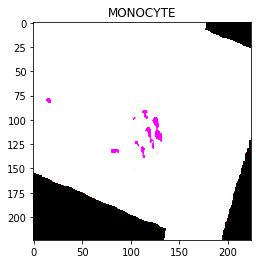

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/16
311/311 [==============================] - 252s 812ms/step - loss: 0.9484 - acc: 0.6050 - val_loss: 2.1865 - val_acc: 0.3705
Epoch 2/16
311/311 [==============================] - 245s 787ms/step - loss: 0.6390 - acc: 0.7525 - val_loss: 3.6472 - val_acc: 0.3161
Epoch 3/16
311/311 [==============================] - 248s 799ms/step - loss: 0.5466 - acc: 0.7889 - val_loss: 3.1266 - val_acc: 0.3536
Epoch 4/16
311/311 [==============================] - 236s 758ms/step - loss: 0.4863 - acc: 0.8172 - val_loss: 3.0666 - val_acc: 0.3475
Epoch 5/16
311/311 [==============================] - 237s 761ms/step - loss: 0.4380 - acc: 0.8369 - val_loss: 3.8002 - val_acc: 0.3442
Epoch 6/16
311/311 [==============================] - 253s 813ms/step - loss: 0.4163 - acc: 0.8407 - val_loss: 3.9663 - val_acc: 0.3426
Epoch 7/16
311/311 [==============================] - 252s 811ms/step - loss: 0.3917 - acc: 0.8503 -

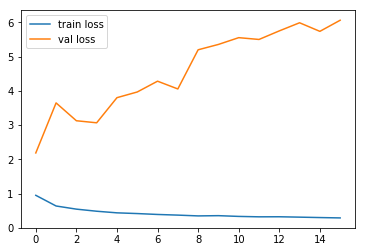

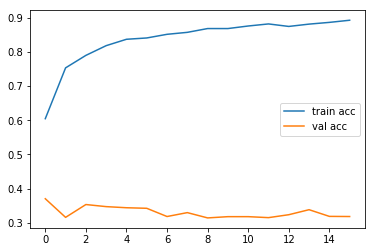

Confusion matrix, without normalization
[[   1  261 2234    1]
 [   0  780 1702    1]
 [   0   87 2391    0]
 [   1  222 2268    8]]


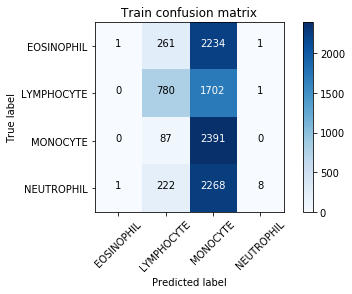

Confusion matrix, without normalization
[[  1 102 519   1]
 [  0 191 429   0]
 [  0   9 611   0]
 [  0  59 563   2]]


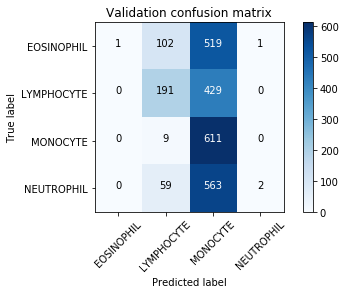

In [4]:

from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 16
batch_size = 32

# https://www.kaggle.com/paultimothymooney/blood-cells
train_path = '../large_files/blood_cell_images/TRAIN'
valid_path = '../large_files/blood_cell_images/TEST'

# https://www.kaggle.com/moltean/fruits
# train_path = '../large_files/fruits-360/Training'
# valid_path = '../large_files/fruits-360/Validation'
# train_path = '../large_files/fruits-360-small/Training'
# valid_path = '../large_files/fruits-360-small/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

print(len(folders))
# look at an image for fun
# plt.imshow(image.load_img(np.random.choice(image_files)))
# plt.show()


# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=res.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)



def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

### Restnet in Fruit dataset

5


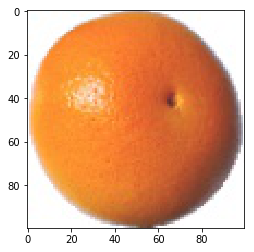

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -84.939 max: 151.061


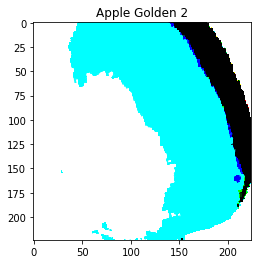

Found 29228 images belonging to 60 classes.
Found 9837 images belonging to 60 classes.
Epoch 1/5
913/913 [==============================] - 413s 453ms/step - loss: 0.2482 - acc: 0.9442 - val_loss: 1.7204 - val_acc: 0.6242
Epoch 2/5
913/913 [==============================] - 394s 432ms/step - loss: 0.0207 - acc: 0.9937 - val_loss: 1.8614 - val_acc: 0.6417
Epoch 3/5
913/913 [==============================] - 431s 472ms/step - loss: 0.0131 - acc: 0.9959 - val_loss: 1.6600 - val_acc: 0.6869
Epoch 4/5
913/913 [==============================] - 437s 478ms/step - loss: 0.0093 - acc: 0.9972 - val_loss: 1.8919 - val_acc: 0.6792
Epoch 5/5
913/913 [==============================] - 418s 457ms/step - loss: 0.0079 - acc: 0.9975 - val_loss: 2.1025 - val_acc: 0.6842
Generating confusion matrix 29228
Found 29228 images belonging to 60 classes.
50
100
150
200
250
300
350
400
450
[[453   0   0 ...   0   0   0]
 [  0 438  49 ...   0   0   0]
 [  0   0 492 ...   0   0   0]
 ...
 [  0   0   0 ... 471   0  

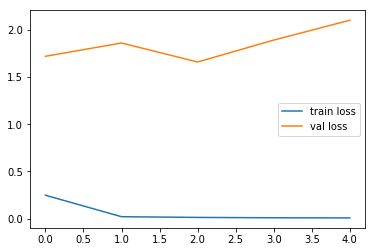

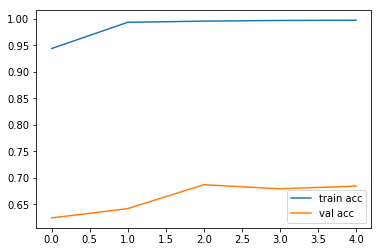

Confusion matrix, without normalization
[[453   0   0 ...   0   0   0]
 [  0 438  49 ...   0   0   0]
 [  0   0 492 ...   0   0   0]
 ...
 [  0   0   0 ... 471   0   0]
 [  0   0   0 ...   0 487   0]
 [  2   0   0 ...   0   0 262]]


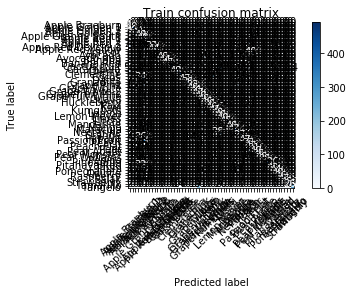

Confusion matrix, without normalization
[[162   0   0 ...   0   0   0]
 [  0 146  16 ...   0   0   0]
 [  0   0 164 ...   0   0   0]
 ...
 [  0   0   0 ... 162   0   0]
 [  0   0   0 ...   0 163   0]
 [  1   0   0 ...   0   0  87]]


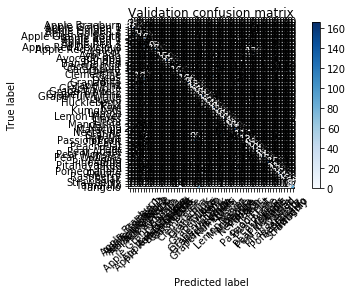

In [11]:
print(5)
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


# re-size all the images to this
IMAGE_SIZE = [224, 224]
epochs = 5
batch_size = 32


# https://www.kaggle.com/moltean/fruits
train_path = '../large_files/fruits-360/Training'
valid_path = '../large_files/fruits-360/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()


# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=res.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)



def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

# 3 - SSD Single-Shot Detection

<img src="images/SSDmodel.png" style="width:1050px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **SSD Model** Multi-scale for detect features map.</center></caption> <br> <br> <br>
    
<img src="images/SSDidea.png" style="width:1050px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 6** </u><font color='purple'>  : **SSD Idea** Multi-scale for detect features map & multi-bounding boxs.</center></caption>
<br>Truncated code. Find more in object_detection_tutorial file.

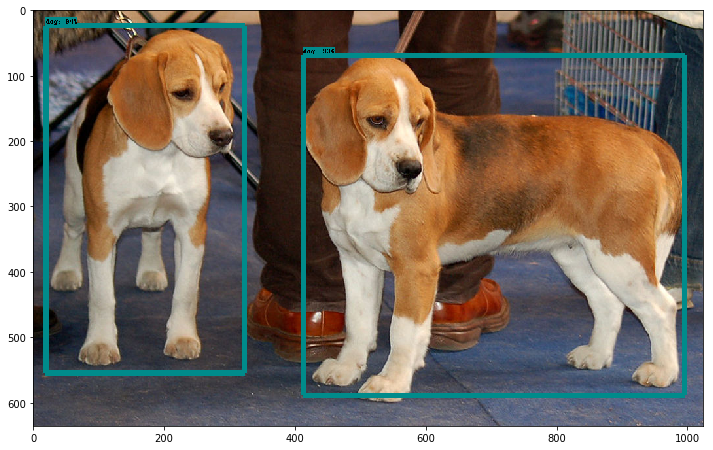

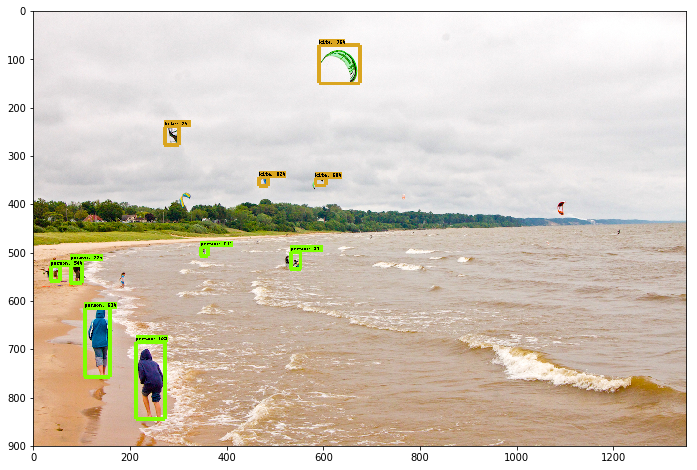

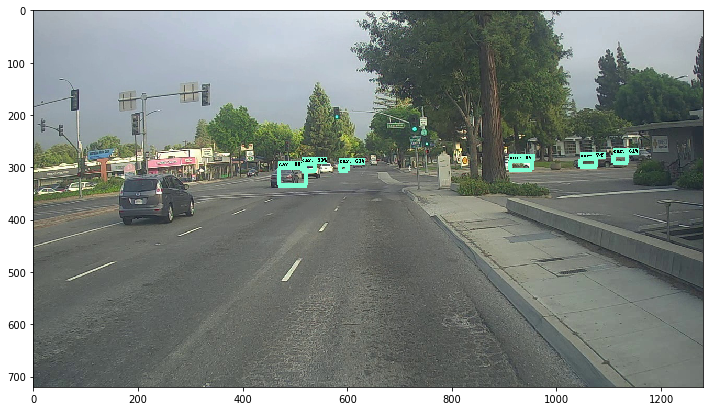

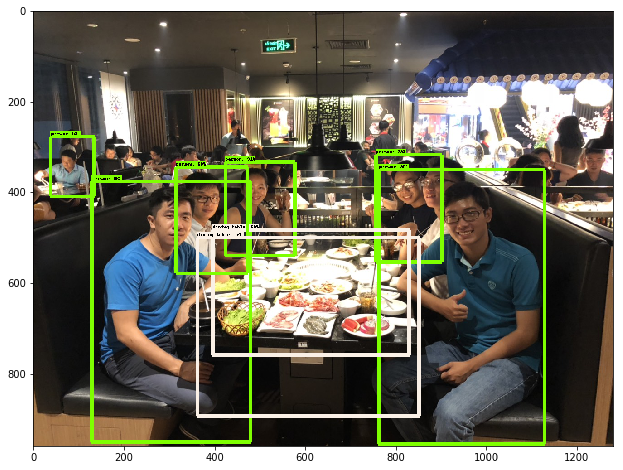

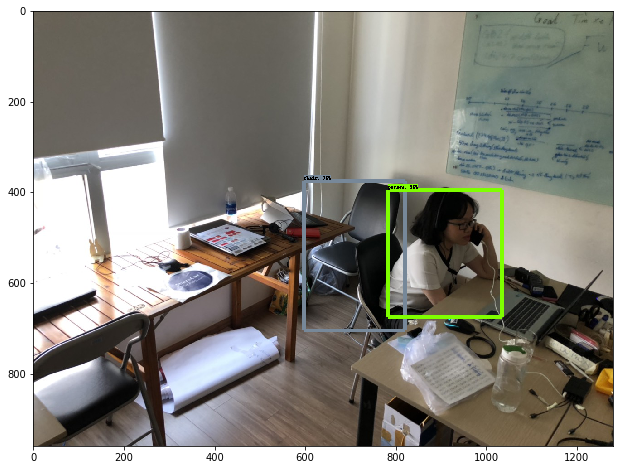

In [30]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

# 4 - Style Neural Transform
Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">

** 4.1 - How do you ensure the generated image G matches the content of the image C?**

The earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes. 

We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. In practice, you'll get the most visually pleasing results if you choose a layer in the middle of the network--neither too shallow nor too deep. (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

So, suppose you have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $$a^{(G)}$$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. (Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style const $J_{style}$.)

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">



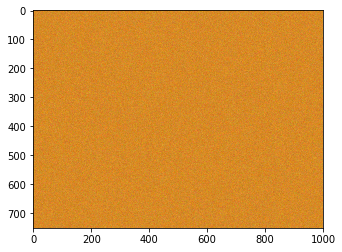

generate img shape: (2250000,)
iter=0, loss=65.69464111328125
iter=1, loss=35.74020004272461
iter=2, loss=24.73658561706543
iter=3, loss=19.302980422973633
iter=4, loss=16.233505249023438
iter=5, loss=14.195858001708984
iter=6, loss=12.826396942138672
iter=7, loss=11.742080688476562
iter=8, loss=10.86666202545166
iter=9, loss=10.26200008392334
duration: 0:01:25.717585


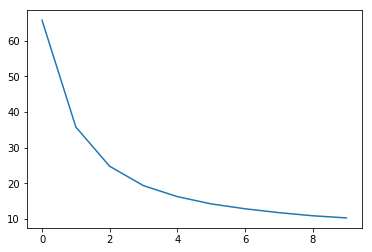

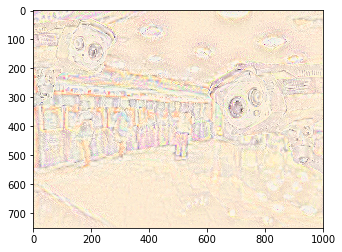

In [15]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

# In this script, we will focus on generating the content
# E.g. given an image, can we recreate the same image

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from skimage.transform import resize
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b



def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)

  return new_model

def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  new_model = Sequential()
  n = 0
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    new_model.add(layer)
    if n >= num_convs:
      break

  return new_model


def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x


if __name__ == '__main__':

  # open an image
  # feel free to try your own
  # path = '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg'
  path = 'content/eyeq-bank.jpg'
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # we'll use this throughout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]

  # see the image
  # plt.imshow(img)
  # plt.show()


  # make a content model
  # try different cutoffs to see the images that result
  content_model = VGG16_AvgPool_CutOff(shape, 11)

  # make the target
  target = K.variable(content_model.predict(x))


  # try to match the image

  # define our loss in keras
  loss = K.mean(K.square(target - content_model.output))

  # gradients which are needed by the optimizer
  grads = K.gradients(loss, content_model.input)

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)



  from datetime import datetime
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)


  plt.imshow(scale_img(final_img[0]))
  plt.show()

  print("generate img shape:",x.shape)
  for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0=x,
      # bounds=[[-127, 127]]*len(x.flatten()),
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)


  plt.imshow(scale_img(final_img[0]))
  plt.show()


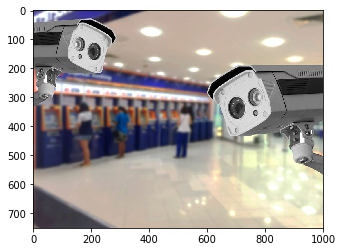

In [27]:
path = 'content/eyeq-bank.jpg'
img = image.load_img(path)
plt.imshow(img)
plt.show()

### 4.2 - Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context. 

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image. 

After generating the Style matrix (Gram matrix), we will minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  



iter=0, loss=12438.28125
iter=1, loss=1605.79345703125
iter=2, loss=683.5252685546875
iter=3, loss=390.0245056152344
iter=4, loss=228.07464599609375
iter=5, loss=159.47740173339844
iter=6, loss=118.76325225830078
iter=7, loss=92.57685089111328
iter=8, loss=73.7221908569336
iter=9, loss=61.74374771118164
duration: 0:00:17.655002


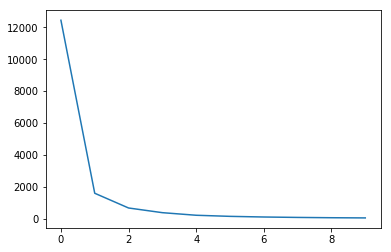

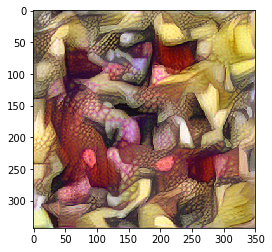

In [8]:
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G


def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


# let's generalize this and put it into a function
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]


if __name__ == '__main__':
  # try these, or pick your own!
#   path = 'styles/starrynight.jpg'
  path = 'styles/flowercarrier.jpg'
  # path = 'styles/monalisa.jpg'
  # path = 'styles/lesdemoisellesdavignon.jpg'


  # load the data
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)

  # look at the image
  # plt.imshow(x)
  # plt.show()

  # make it (1, H, W, C)
  x = np.expand_dims(x, axis=0)

  # preprocess into VGG expected format
  x = preprocess_input(x)

  # we'll use this throughout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]

  # let's take the first convolution at each block of convolutions
  # to be our target outputs
  # remember that you can print out the model summary if you want
  vgg = VGG16_AvgPool(shape)

  # Note: need to select output at index 1, since outputs at
  # index 0 correspond to the original vgg with maxpool
  symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
  ]

  # pick the earlier layers for
  # a more "localized" representation
  # this is opposed to the content model
  # where the later layers represent a more "global" structure
  # symbolic_conv_outputs = symbolic_conv_outputs[:2]

  # make a big model that outputs multiple layers' outputs
  multi_output_model = Model(vgg.input, symbolic_conv_outputs)

  # calculate the targets that are output at each layer
  style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

  # calculate the total style loss
  loss = 0
  for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

  grads = K.gradients(loss, multi_output_model.input)

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[multi_output_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


  final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
  plt.imshow(scale_img(final_img))
  plt.show()


### 4.3 - Defining the total cost to optimize
Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$



iter=0, loss=4619.119140625
iter=1, loss=1175.7576904296875
iter=2, loss=711.09765625
iter=3, loss=529.0372924804688
iter=4, loss=437.3094482421875
iter=5, loss=379.6900329589844
iter=6, loss=338.99468994140625
iter=7, loss=307.83380126953125
iter=8, loss=284.1689147949219
iter=9, loss=264.1792907714844
iter=10, loss=246.6589813232422
iter=11, loss=229.7480926513672
iter=12, loss=217.01205444335938
iter=13, loss=204.78033447265625
iter=14, loss=193.8111572265625
iter=15, loss=184.5727996826172
iter=16, loss=176.4353485107422
iter=17, loss=169.5490264892578
iter=18, loss=163.5563201904297
iter=19, loss=158.07859802246094
duration: 0:03:16.974747


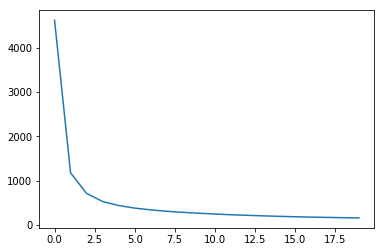

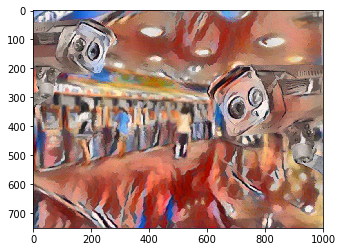

In [28]:
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x



content_img = load_img_and_preprocess(
  # '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg',
  # 'batman.jpg',
  'content/eyeq-bank.jpg',
  # (225, 300),
)

# resize the style image
# since we don't care too much about warping it
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
  # 'styles/starrynight.jpg',
  # 'styles/flowercarrier.jpg',
  # 'styles/monalisa.jpg',
  'styles/lesdemoisellesdavignon.jpg',
  (h, w)
)


# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]


# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)


# create the content model
# we only want 1 output
# remember you can call vgg.summary() to see a list of layers
# 1,2,4,5,7-9,11-13,15-17
content_model = Model(vgg.input, vgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))


# create the style model
# we want multiple outputs
# we will take the same approach as in style_transfer2.py
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [0.2,0.4,0.3,0.5,0.2]



# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])


# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

# just like theano.function
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

print("Loading...")

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 20, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()


Content Img


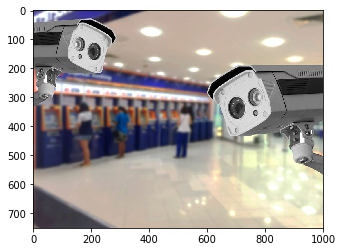

Style Img


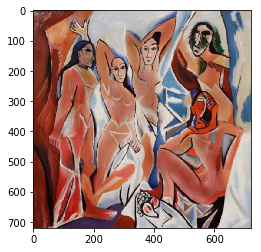

In [29]:
print("Content Img")
path = 'content/eyeq-bank.jpg'
img = image.load_img(path)
plt.imshow(img)
plt.show()

print("Style Img")

path = 'styles/lesdemoisellesdavignon.jpg'
img = image.load_img(path)
plt.imshow(img)
plt.show()